In [1]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Make RBC Model](#chapter1)
    * [Model Equations](#section_1_1)
    * [Find Steady State, Solve the Model](#section_1_2)
* [Get Italy data](#chapter2)
* [Preprocessing the data](#chapter3)
    * [Log-Transforming of the Data](#section_3_1)
    * [Detrending the Data](#section_3_2)
    * [Detrending the Data](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [MLE Kalman Filter Prediction](#section_4_1)
    * [Kalman Smoother output](#section_4_2)
    * [Impulse response](#section_4_3)

In [2]:
%matplotlib inline
# import gEcon as ge
# import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import arviz as az
import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df

# from TimeSeriesTools.stats import ADF_test_summary
# from TimeSeriesTools.transformers import DetrendTransformer, LogTransformer

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

## Make RBC Model <a class="anchor" id="chapter1"></a>

In [3]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc.gnc'))

NameError: name 'ge' is not defined

### Model Equations  c

In [165]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

### Find Steady State, Solve the Model <a class="anchor" id="section_1_2"></a>

In [166]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.0823547763477462e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [167]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


## Get Italy data <a class="anchor" id="chapter2"></a>

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

data.drop(["X", "Z"], axis=1, inplace=True)

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In [4]:
# check for na
data.isna().sum()
df = data.copy()

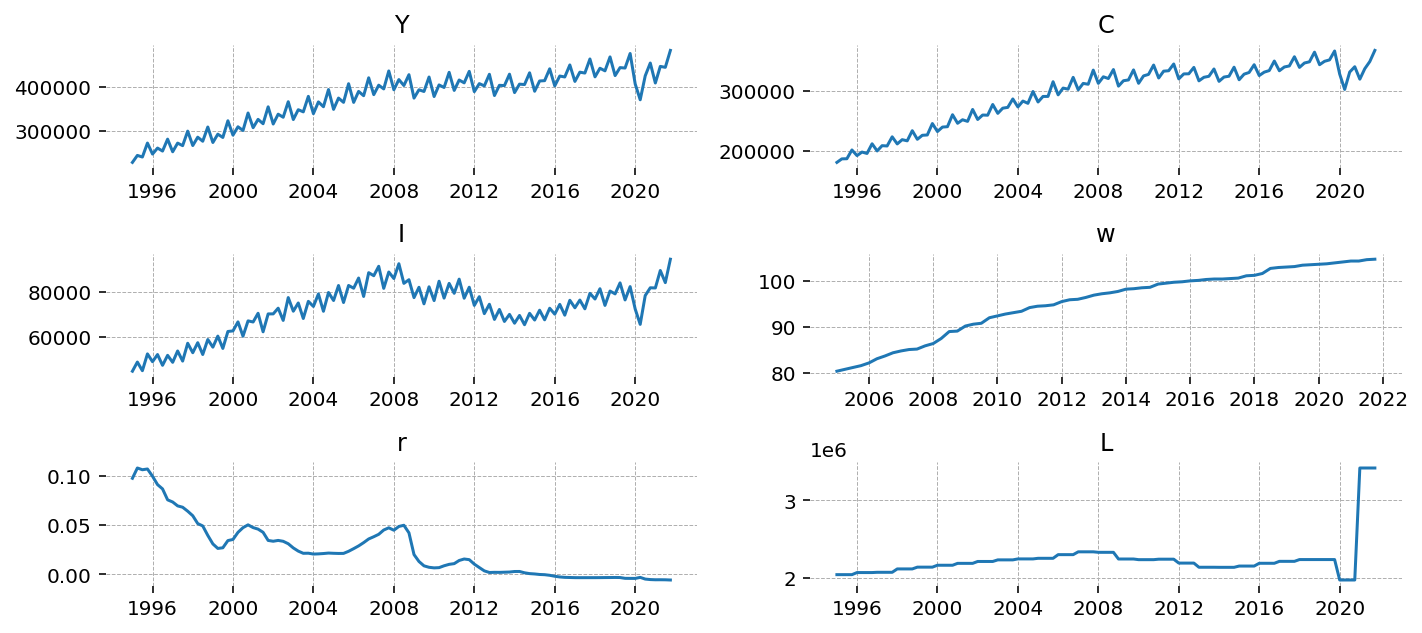

In [5]:
plot_df(data)

### Log-transformation <a class="anchor" id="section_3_1"></a>

In [58]:
def transform(arr: pd.Series, func, skip_na: bool=False, **kwargs):
    if skip_na:
        arr_ = arr[~arr.isna()].copy()
        arr_ = func(arr_, **kwargs)
        arr[~arr.isna()] = arr_
        return arr
    else:
        return func(arr, **kwargs)

In [49]:
df = data.copy()
for col in df.columns:
    df[col] = transform(df[col], np.log1p)

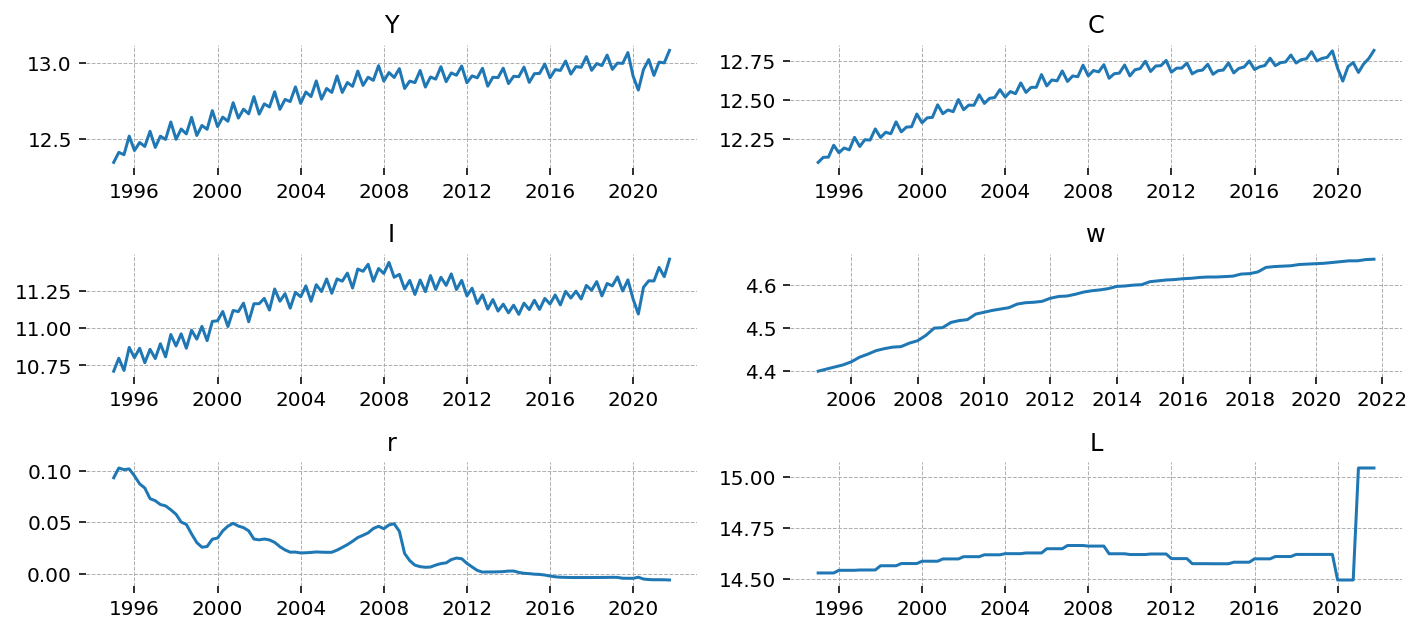

In [50]:
plot_df(df)

### Deseasonalise the Data <a class="anchor" id="section_3_2"></a>

In [51]:
def get_seasonal_decompose(arr: pd.Series, plot: bool=True, **kwargs):
    """
    returns remainder after trend and seasonal
    """
    res = sm.tsa.seasonal_decompose(arr, **kwargs)
    res.plot() if plot is True else 0
    return res.seasonal, res.trend

def get_seasonal_hp(arr: pd.Series, plot: bool=True, lamb:float = 6.25, **kwargs):
    """
    returns: cycle, trend
    """
    cycle, trend = statsmodels.tsa.filters.hp_filter.hpfilter(data.Y, lamb=lamb)
    plt.plot(np.array([cycle, trend]).transpose()) if plot is True else 0
    return cycle, trend

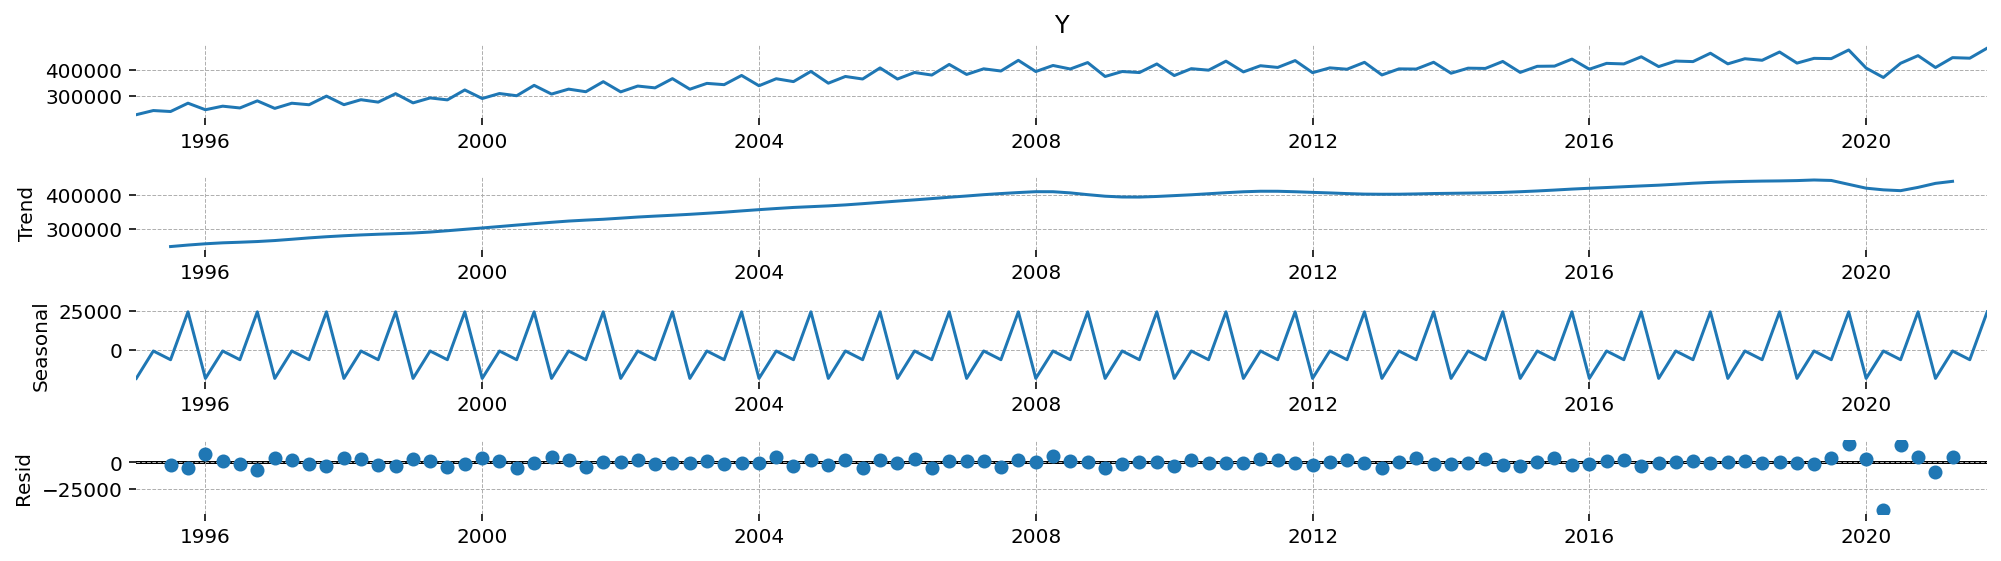

In [52]:
cyc1, tren1 = get_seasonal_decompose(data.Y);

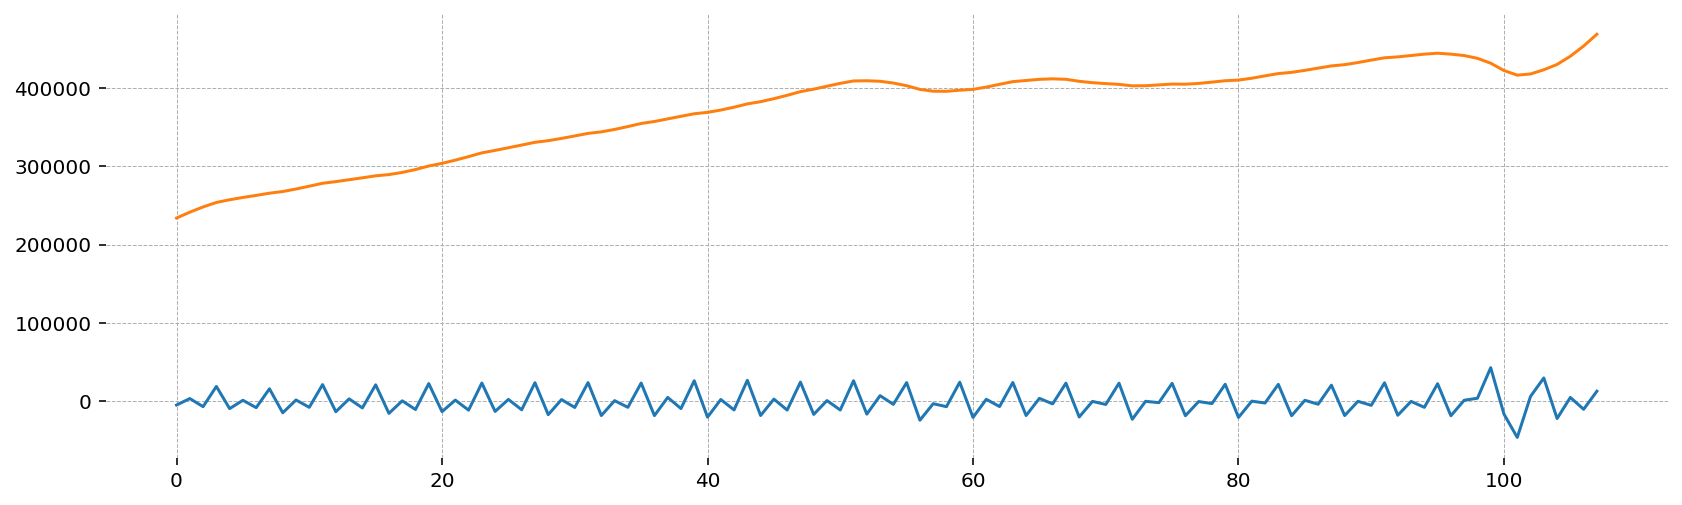

In [53]:
cyc2, tren2 = get_seasonal_hp(data.Y);

In [54]:
desea_cols = ['Y', 'I', 'C']
for col in desea_cols:
    _, df[col] = get_seasonal_hp(df[col], plot=False)

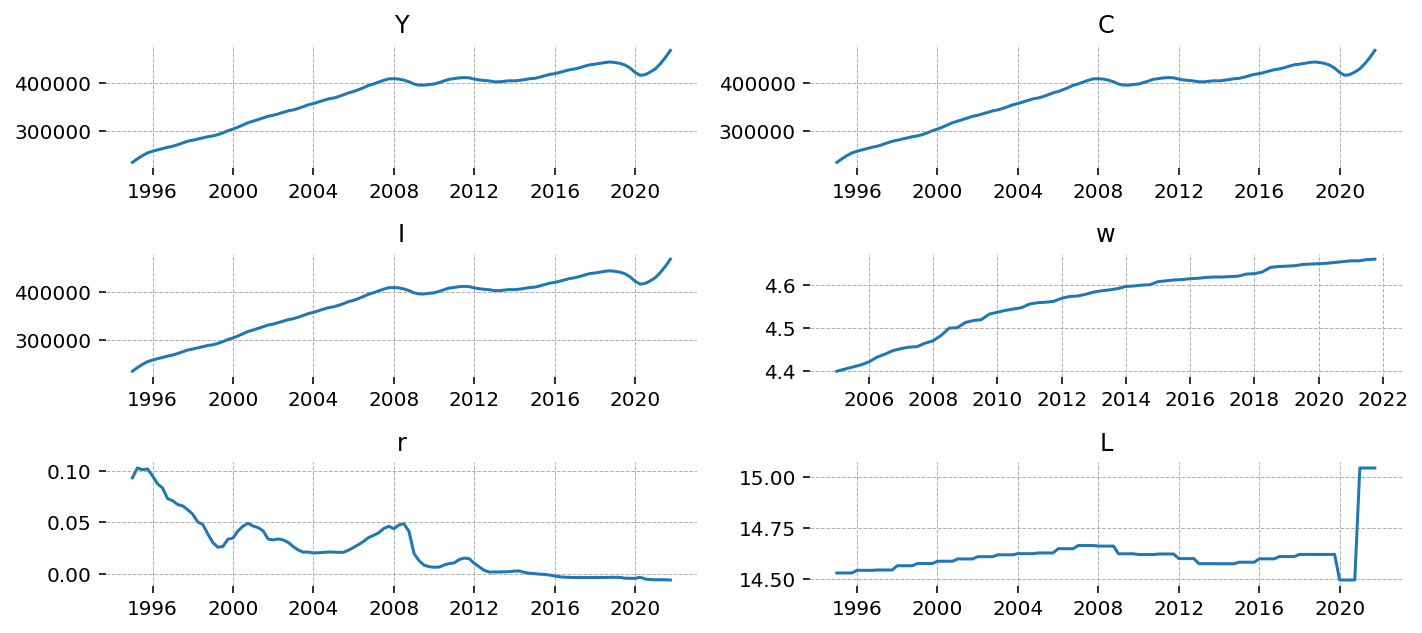

In [55]:
plot_df(df)

#### detrend

In [56]:
df.isna().sum()

Y     0
I     0
r     0
C     0
w    40
L     0
dtype: int64

In [59]:
for col in df.columns:
    df[col] = transform(df[col], scipy.signal.detrend, skip_na=True)

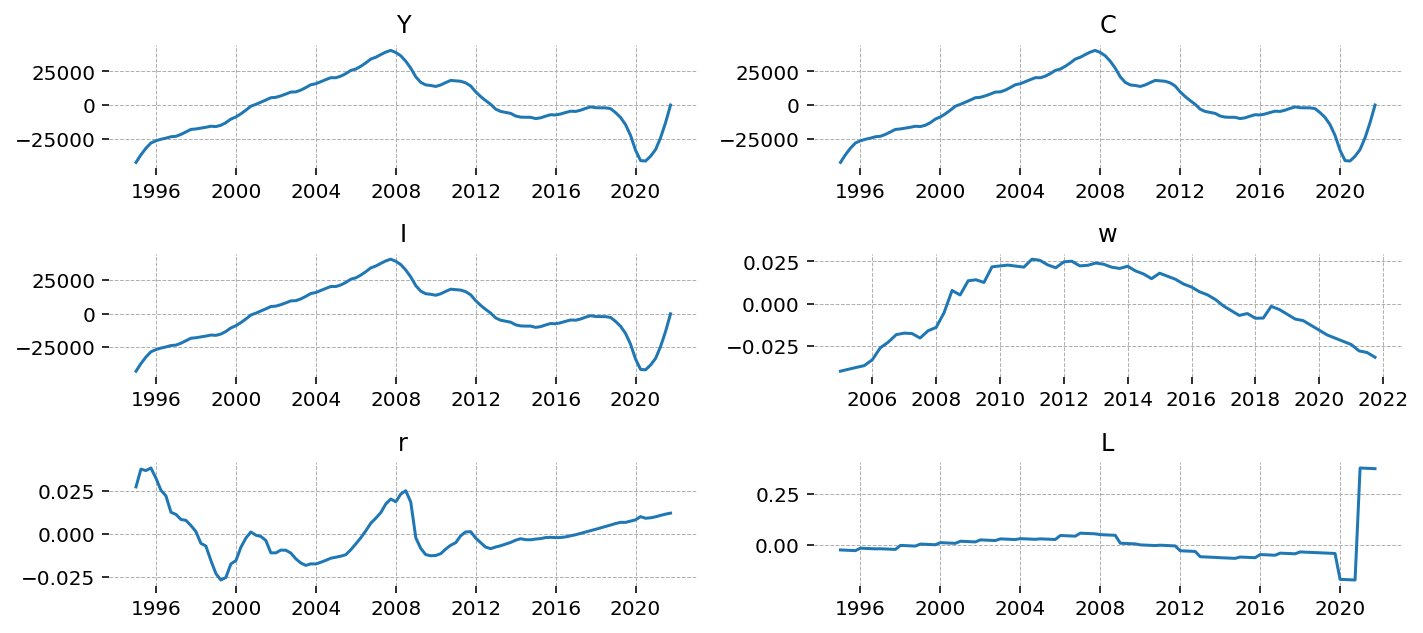

In [60]:
plot_df(df)

### Check stationarity after tranformation <a class="anchor" id="section_3_3"></a>

In [61]:
from statsmodels.tsa.stattools import adfuller

In [62]:
def arr_adf(arr, maxlag: int=10, reject_level: float=.05):
    """
    The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root - non-stationarity
    """
    test = adfuller(arr, maxlag=maxlag)
    print(arr.name, f" p-val: {test[1]}, reject: {test[1] <= reject_level}")
    pass
    

## Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [143]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [144]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52, 'delta':0.01} 
rbc.free_param_dict.update(calibrated_params)

In [145]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# NOTE: We have to change this parameters probably

param_start_dict = {'sigma_C':1.5, 
                    'sigma_L':2.0,
#                     'alpha':0.5,
                    'rho_A':0.85}

shock_start_dict = {
    'epsilon_A':0.5
}

noise_start_dict = {
#     'Y':0.01,
    'C':0.02,
    'L':0.05,
    'I':0.02,
    'r':0.03,
    'w':0.1
}

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
    'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-4, high=0.99, slope=1),
#     'alpha':IntervalTransformer(low=0.1, high=0.80, slope=1)
}

mle_mod = MLEModel(df,
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [146]:
mle_res = mle_mod.fit(method='nm', maxiter=10_000)
mle_res = mle_mod.fit(method='lbfgs', maxiter=1_000, start_params=mle_res.params)

Optimization terminated successfully.
         Current function value: -34.947347
         Iterations: 770
         Function evaluations: 1183


In [147]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'I', 'r', 'C', 'w', 'L']   No. Observations:                   52
Model:                                  DSGEModel   Log Likelihood                1130.007
Date:                            Fri, 25 Nov 2022   AIC                          -2242.015
Time:                                    13:10:42   BIC                          -2224.453
Sample:                                01-01-2007   HQIC                         -2235.282
                                     - 10-01-2019                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma_C              1.0642    255.890      0.004      0.997    -500.470     502.599
sigma_L              1.2078     14.962      0.081      0.936     -28.117      30.532
rho_A                0.8861      5.282      0.168      0.867      -9.467      11.240
sigma2.epsilon_A     0.0001      0.056      0.002      0.999      -0.110       0.110
sigma2.C             0.0002      0.286      0.001      0.999      -0.560       0.560
sigma2.L             0.0002      0.186      0.001      0.999      -0.365       0.365
sigma2.I          5.768e-05      0.369      0.000      1.000      -0.724       0.724
sigma2.r          8.913e-05      0.422      0.000      1.000      -0.827       0.827
sigma2.w          5.259e-05      0.106      0.000      1.000      -0.208       0.208
================================================================================================================================
Ljung-Box (L1) (Q):     5.15, 0.62, 1.75, 1.80, 2.04, 12.35   Jarque-Bera (JB):   267.91, 331.15, 31.77, 1025.52, 164.29, 178.44
Prob(Q):                 0.02, 0.43, 0.19, 0.18, 0.15, 0.00   Prob(JB):                       0.00, 0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 8.07, 4.03, 0.41, 26.46, 1.98, 8.04   Skew:                       -0.26, -2.27, -1.27, 3.33, -1.30, 1.20
Prob(H) (two-sided):     0.00, 0.01, 0.07, 0.00, 0.17, 0.00   Kurtosis:                  14.11, 14.50, 5.86, 23.71, 11.31, 11.75
================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+18. Standard errors may be unstable.
"""

## MLE Kalman Filter Prediction <a class="anchor" id="section_4_1"></a>

In [157]:
def plot_sm_results(res, filter_output='predicted'):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = mle_res.states.predicted.columns
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(mle_res.data.dates, mu.values[start_idx:], label='Predicted')
#         axis.fill_between(mle_res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            mle_res.data.orig_endog[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

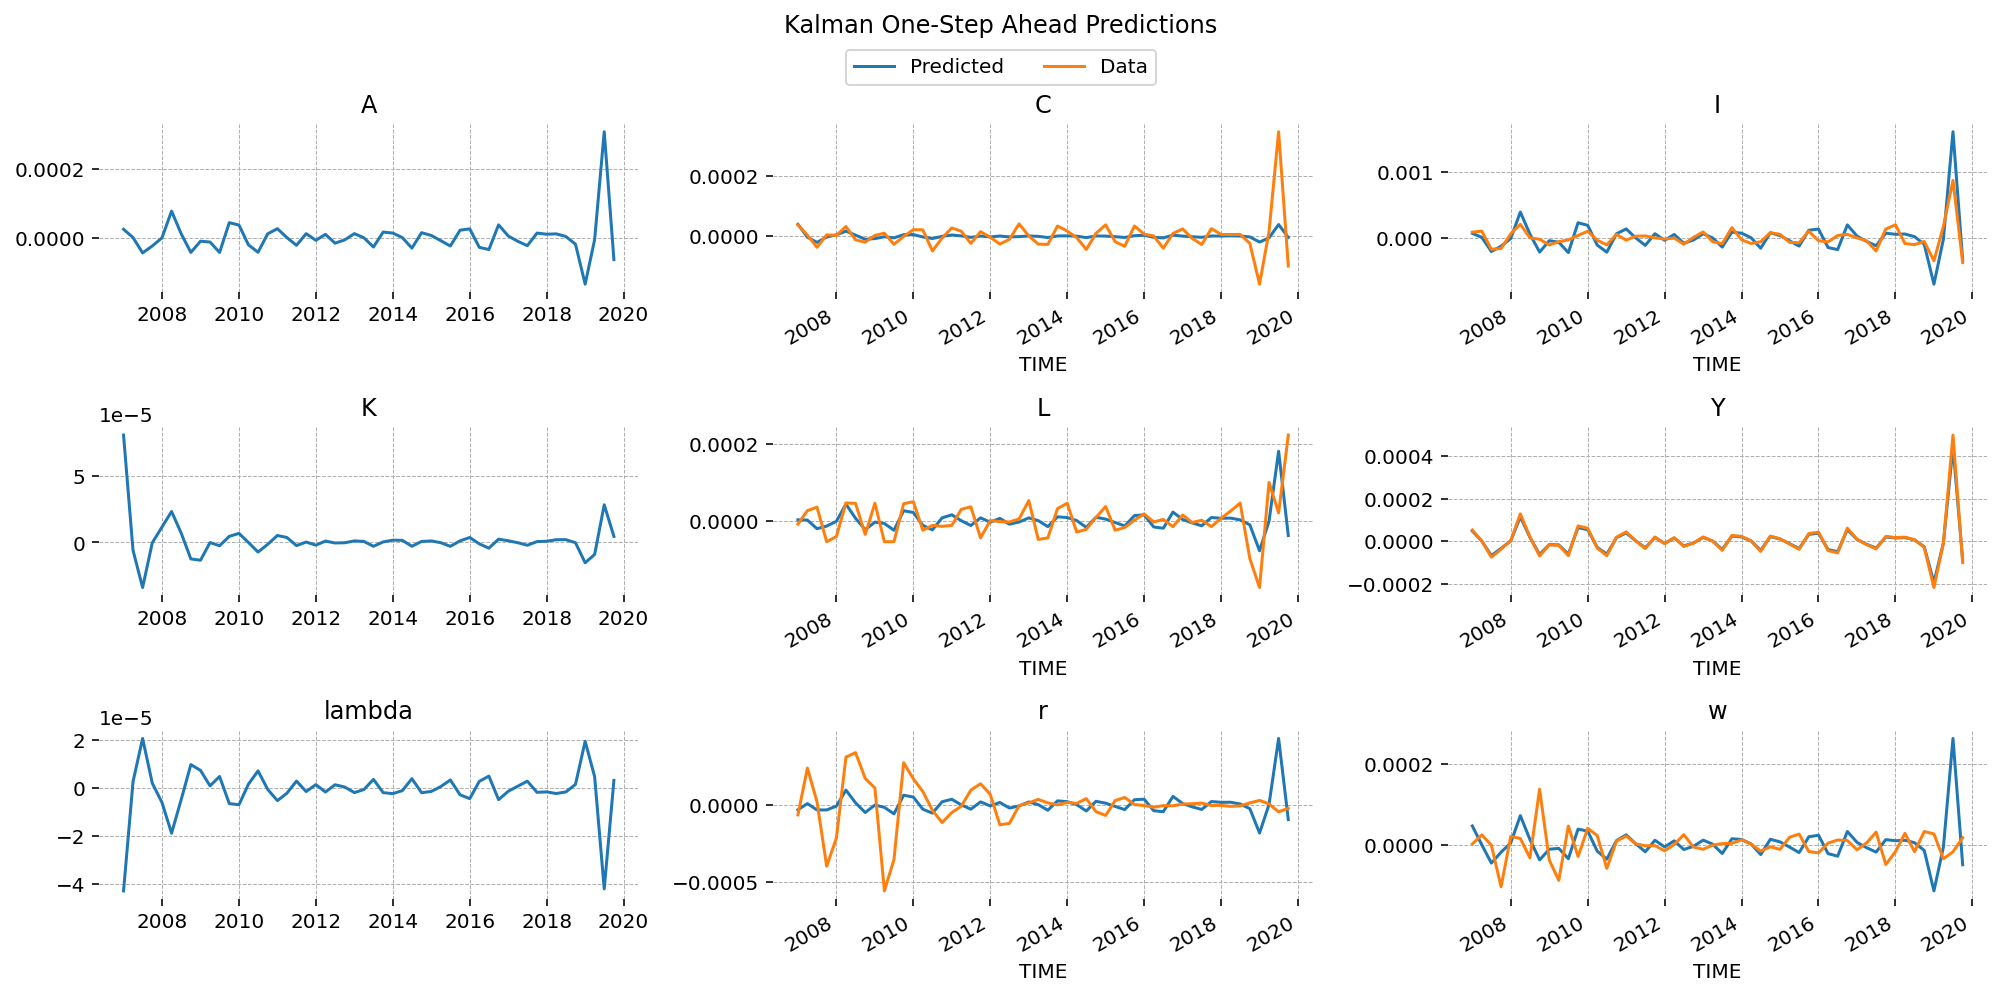

In [158]:
plot_sm_results(mle_res)

## Kalman Smoother output <a class="anchor" id="section_4_2"></a>

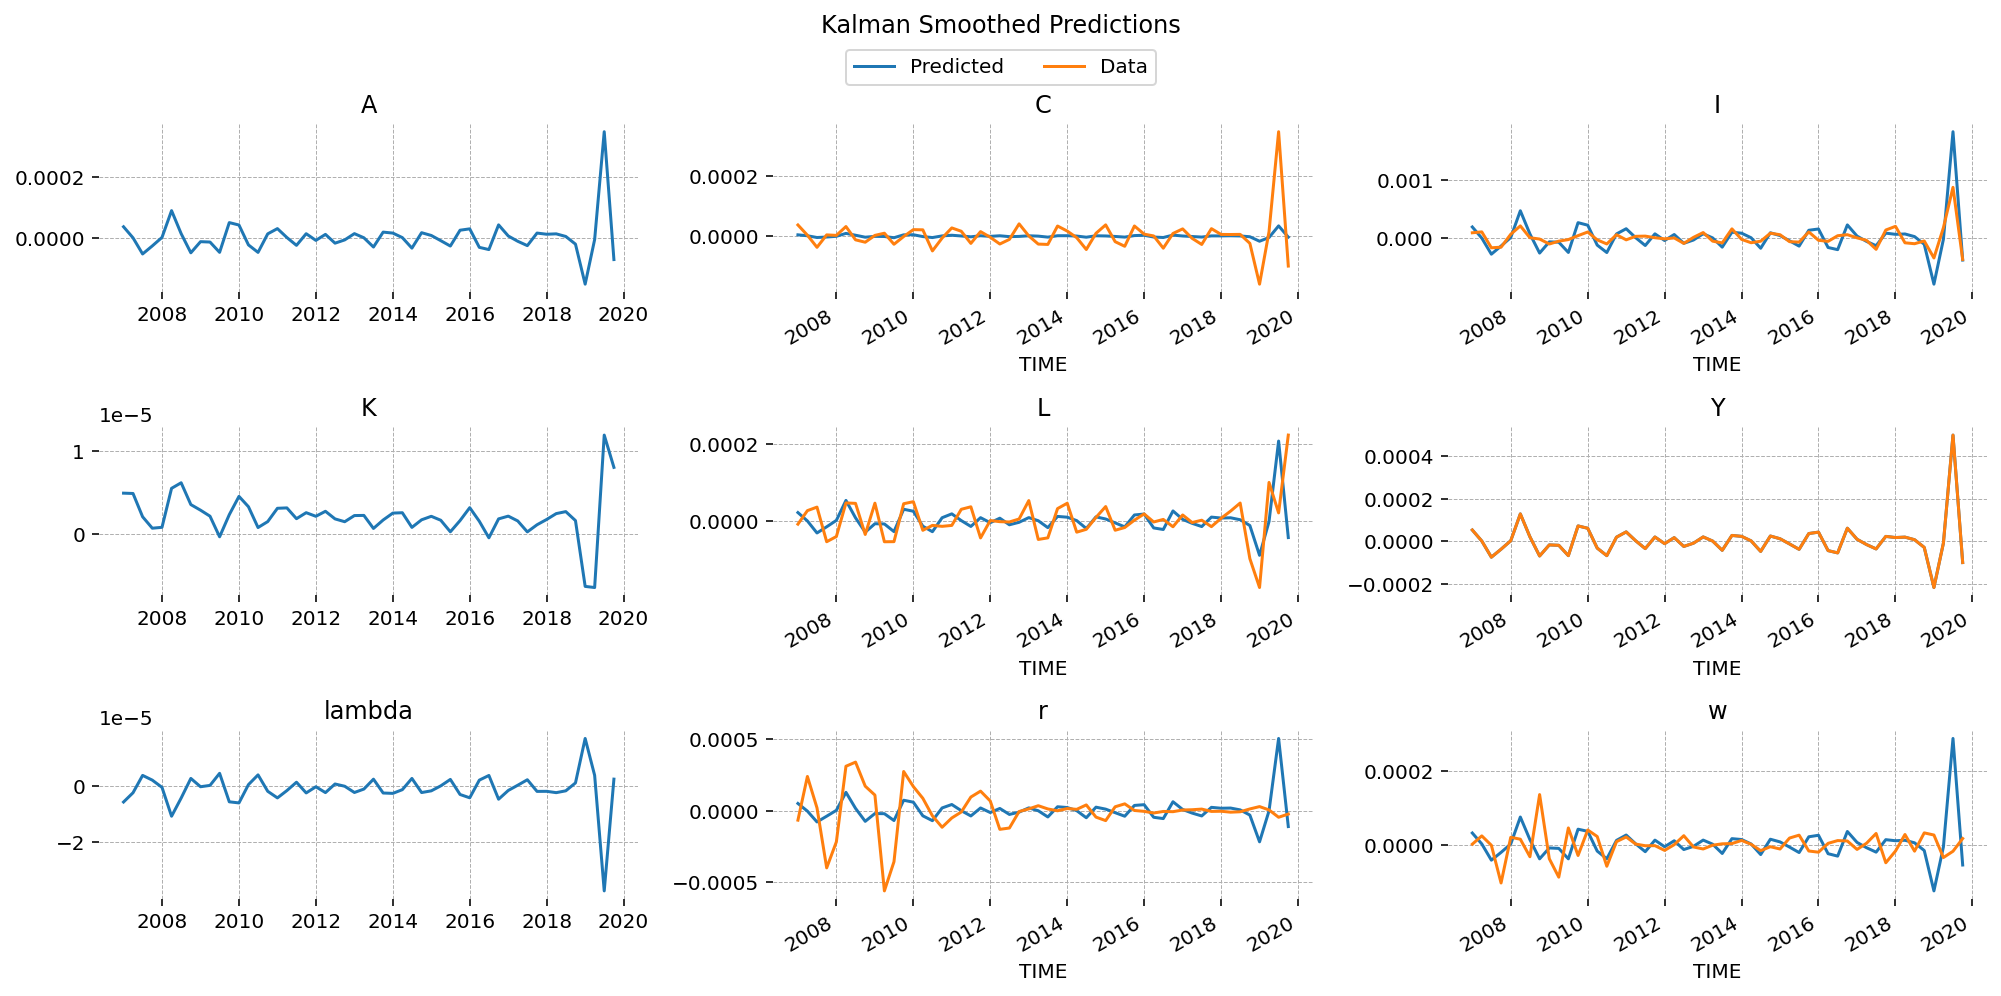

In [159]:
plot_sm_results(mle_res, 'smoothed')

## Impulse response <a class="anchor" id="section_4_3"></a>

In [160]:
irf_df = mle_res.impulse_responses(impulse=0, steps=40, orthogonalized=False)
irf_df.index = pd.MultiIndex.from_product([irf_df.index, ['epsilon_A']], names=['Time', 'Shocks'])
irf_df.columns.name = 'Variables'

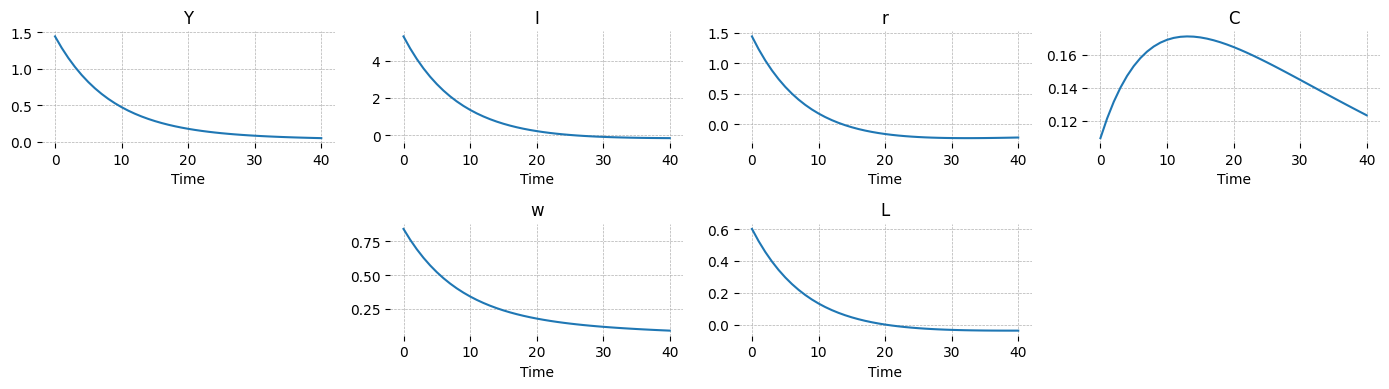

In [161]:
fig = gp.plot_irf(irf_df.T, shocks_to_plot='epsilon_A', figsize=(14,4))
plt.show()